<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/03_pyth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.3 Computer Vision

### Computer based libraries in PyTorch

* `torchvision` : Base domain library for PyTorch Computer Vision
* `torchvision.datasets` : Get datasets and data loading functions
* `torchvision.models`: Get pretrained CV models (alr been trained on some vision data)
* `torchvision.transforms` : Functions for manipulating your vision data(images) to be suitable for use with an ML model
* `torch.utils.data.Dataset`: Base dataset class for PyTorch
* `torch.utils.data.DataLoader`: Creates a python iterable over a dataset

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # Convert PIL image or numpy.ndarray

# import matplotlib
import matplotlib.pyplot as plt

# check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


### 1. Getting a dataset

The data we will be using is FashionMNIST! - grey scale images of clothing items (upgraded MNIST which is grey scale image data of handwritten digits).

This is a built-in dataset in torchvision.datasets ! Torch vision also has a bunch of other data sets :0

These are mostly pre-formatted to be used with PyTorch unlike your custom datasets.

In [2]:
# Training data

train_data = datasets.FashionMNIST(
    root="data", # where to download data
    train=True, # already formatted into train , if false we get Test!
    download=True, # do we want to download images? yes here
    transform=torchvision.transforms.ToTensor(), #how do we want to transform the data
    target_transform=None # how do we want to transform labels
)

# Testing data:

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = ToTensor(),
    target_transform = None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
print(f'Image shape: {image.shape} -> [color channels, height, width]') # gray scale so c = 1(color channels first), C,W,H

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]


In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx # gives a dictionary with mapped category values!

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.2 Visualising our data

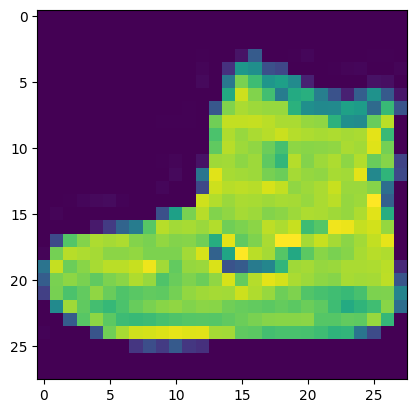

In [7]:
image, label = train_data[0]
# plt.imshow(image) # because c, w, h

#matplotlib expects color channels at last

plt.imshow(image.squeeze()) # remove extra 1 dim

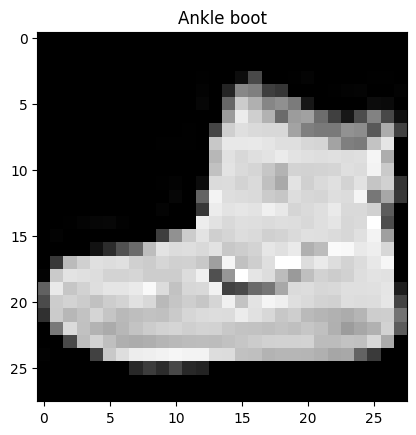

In [8]:
plt.imshow(image.squeeze(), cmap="gray");
plt.title(class_names[label]);

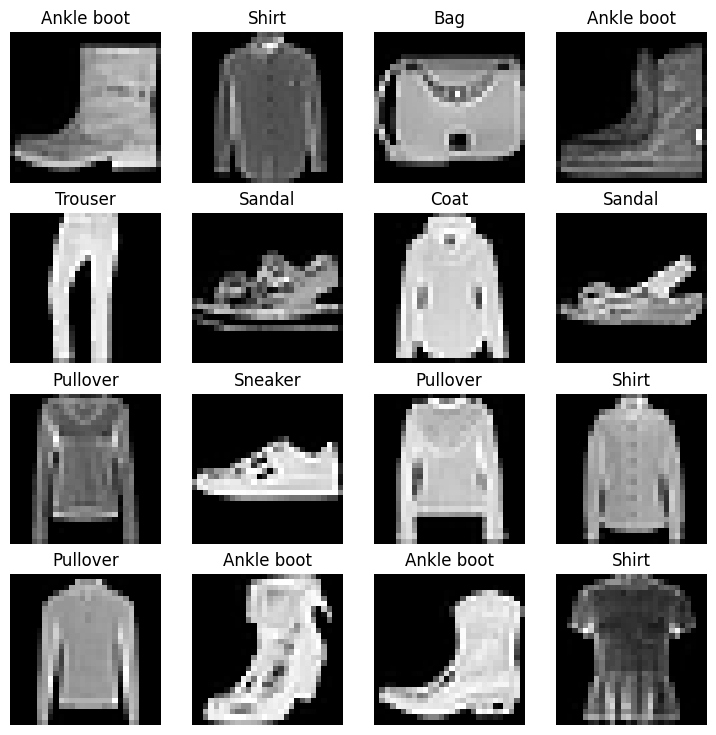

In [9]:
# Plot random images

torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing , could be modelled with pure linear linear or we shall need non-linearity? - the latter prob!

### 2. Prepare DataLoader

Right now, our data is in form of PyTorch datasets. We use dataloaders to convert into python iterables.


More specifically, want to turn data into batches. **But why?** Computer hardware cannot look at 60K images at a time, memory won't work. Hence, we break it into mini-batches. Because:

- It is more computationally efficient. cannot process/(store in memory) 60k images in one hit. Hence break it into looking at 32 images at a time (commonly used)

- Gives our neural network more chances to update its gradients per epoch. Instead of one update per epoch, multiple updates per epoch!

In [10]:
from torch.utils.data import DataLoader

# SET UP HYPERPARAMS

BATCH_SIZE = 32

# Turn datasets into iterables

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # in case data is ordered, we dont want our model to learn the order of images, just the patterns per image

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c9c25c78fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9c25cbe0d0>)

In [11]:
print("Number of train batches of size 32:", len(train_dataloader))
print("Number of test batches of size 32:", len(test_dataloader))

Number of train batches of size 32: 1875
Number of test batches of size 32: 313


In [12]:
# Check out what is inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader)) # turn dataloader into iterable, get the next batch
train_features_batch.shape, train_labels_batch.shape #NCHW, labels for number of images in a batch, so hence 32 images

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label:6


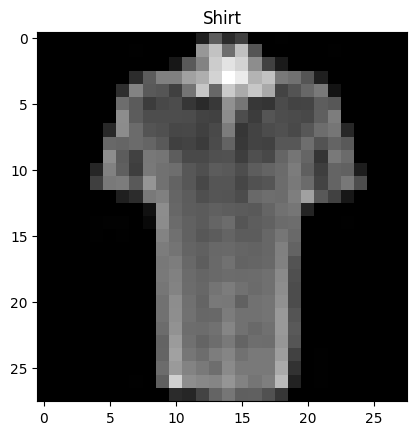

In [13]:
# Show a sample

torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label]);
print(f'Image Size: {img.shape}')
print(f'Label:{label}')

### 3. Model 0: Build a baseline model

Best practice to start with baseline model! It is a simple model, we can try to improve upon it. Add complexity, when necessary, start simple though.

In [14]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample

x = train_features_batch[0]
x.shape
output = flatten_model(x)
print("After flattening the image, the shape is:", output.shape)
print("We have one value per pixel.") # for each color channel it created a 28 x 28 map , h and w are flattened

After flattening the image, the shape is: torch.Size([1, 784])
We have one value per pixel.


In [15]:
# Model Class
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [16]:
# Instantiate a class!

torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, # this is 28*28
                              output_shape=len(class_names),
                              hidden_units=10)

model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand([1,1,28,28])
ans = model_0(dummy_x)
print(ans) # logit values

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)


### 3.1 Pick a loss function and optimizer

loss function -> since multi class classification, hence CrossEntropyLoss

optimizer -> stick with SGD

evaluation metric -> using accuracy!


In [18]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

In [19]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a time function to time our code!

Machine learning is very experimental. Two things we want to track:

1. Model's performance metrics.
2. How fast it runs.


In [20]:
from timeit import default_timer  as timer

def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Total time on {device}: {total_time:.3f} seconds")
  return total_time

In [21]:
start_time = timer()

# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")


Total time on cpu: 0.000 seconds


4.3680999624484684e-05

### 3.3 Creating trainin loop and training a model on batches of data

1. loop thru epochs
2. loop thru training batches, perform training steps, calc train loss PER BATCH
3. loop thru testing batch! calc test loss PER BATCH AS WELL
4. print status
5. time it

In [22]:
# for python progress bar

from tqdm.auto import tqdm # auto recognises system, so it looks at it and then gives us progress bar accordingly

# set seed and start timer

torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set no of epochs - keep small rn

epochs = 3

# create loop for training
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------------')

    ## training
    train_loss = 0 # set zero for every batch
    for batch, (X,y) in enumerate(train_dataloader):
      model_0.train() # put model in train mode
      y_pred = model_0(X) # forward pass

      loss = loss_fn(y_pred, y)
      train_loss += loss # total loss per batch
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 400 == 0:
        print(f'Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples')
    # adjust train loss to get average training loss per batch, divide total train loss by len of train dataloader
    train_loss /= len(train_dataloader) #avg loss per epoch/ per batch

    ## testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
      for X_test,y_test in test_dataloader:
        test_pred = model_0(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
      # Calc test loss average per batch
      test_loss /= len(test_dataloader)
      # Calc test acc average per batch
      test_acc /= len(test_dataloader)
    print(f'\nTrain Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device = str(next(model_0.parameters()).device))
print("Total Time:", total_train_time_model_0)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.59039 | Test Loss: 0.50954 | Test Acc: 0.82039
Epoch: 1
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.47633 | Test Loss: 0.47989 | Test Acc: 0.83197
Epoch: 2
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.45503 | Test Loss: 0.47664 | Test Acc: 0.83427
Total time on cpu: 33.102 seconds
Total Time: 33.102023192999695


### 4. Make Predictions and get Model 0 results

In [35]:
torch.manual_seed(42)
def eval_model(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc:": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = nn.CrossEntropyLoss(),
                             accuracy_fn = accuracy_fn)
model_0_results



  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc:': 0.8342651757188498}

In [24]:
# Set up device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Do we need non-linearity? Let us use that!

In [25]:
# Model Class - with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [26]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              output_shape=len(class_names),
                              hidden_units=10).to(device)

In [27]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

#### Training loop!

In [33]:
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               data_loader: torch.utils.data.DataLoader,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  # Put model into training mode
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X) # forward pass
      loss = loss_fn(y_pred, y)
      train_loss += loss # total loss per batch
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) #from logits to pred labels
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 400 == 0:
        print(f'Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples')
    # adjust train loss to get average training loss per batch, divide total train loss by len of train dataloader
  train_loss /= len(data_loader) #avg loss per epoch/ per batch
  train_acc /= len(data_loader)
  print(f'\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}')


In [32]:
def test_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               data_loader: torch.utils.data.DataLoader,
               accuracy_fn,
               device: torch.device = device):
  """Performs a testing with model trying to learn on data_loader."""
  # Put model into training mode
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X,y in data_loader:
        X,y = X.to(device), y.to(device)
        test_pred = model(X) # forward pass
        test_loss += loss_fn(test_pred, y)# total loss per batch
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) #from logits to pred labels
    test_loss /= len(data_loader) #avg loss per epoch/ per batch
    test_acc /= len(data_loader)
    print(f'\nTest Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}')


In [34]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()
epochs = 3
for epoch in range(epochs):
  # Just call each functions
  train_step(model_1, loss_fn, optimizer, train_dataloader, accuracy_fn, device)
  test_step(model_1, loss_fn, optimizer, test_dataloader, accuracy_fn, device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device = str(next(model_0.parameters()).device))

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 2.30166 | Train Accuracy: 0.11315

Test Loss: 2.30211 | Test Accuracy: 0.10753
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 2.30166 | Train Accuracy: 0.11315

Test Loss: 2.30211 | Test Accuracy: 0.10753
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 2.30166 | Train Accuracy: 0.11315

Test Loss: 2.30211 | Test Accuracy: 0.10753
Total time on cpu: 37.474 seconds


In [31]:
results = eval_model(model_1,data_loader=test_dataloader,loss_fn=loss_fn, accuracy_fn=accuracy_fn)
results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 2.3021068572998047,
 'model_acc:': 0.1075279552715655}

### Why did we do worse :0 ?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.

2. The hardware you'r using has a better CPU in terms of compute capability than the GPU.